In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt
from scipy.stats import logistic
from scipy.special import softmax

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.optimizers import RMSprop, Adam, SGD
from keras.models import Model
from keras.utils import to_categorical
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

from pixelcnn_helpers import pixelcnn_loss, sigmoid, compute_pvals, compute_mixture, PixelConv2D

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [96]:
img_rows, img_cols, img_chns = 4, 4, 3
original_img_size = (img_rows, img_cols, img_chns)

# Debug params
sample = 1

# Hyper params
batch_size = int(os.environ.get('BATCH_SIZE', 1))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
mixture_components = int(os.environ.get('MIXTURE_COMPONENTS', 1))

# Extract Test Image

In [97]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Shift/scale to [-1, 1] interval
X_train = X_train[:sample, :img_rows, :img_cols, :img_chns]
X_train = (X_train - 127.5) / 127.5

X_test = (X_test - 127.5) / 127.5

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1, 4, 4, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


# Model

In [98]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)


def resnet_block(input_tensor, filters, stage, block):
    name_base = str(stage) + block + '_branch'
    filters1, filters2, filters3 = filters
    x = input_tensor
    x = conv_block(x, filters1, (1, 1), name=name_base + '_a-1x1')
    x = conv_block(x, filters2, (3, 3), name=name_base + '_b-3x3')
    x = conv_block(x, filters3, (1, 1), name=name_base + '_c-1x1')
    x = Add()([x, input_tensor])
    
    return x


def final_block(input_tensor, filters, in_filters, name, kernel_size=(1, 1)):
    outs = []
    channel_name = 'rgb'
    for t in ['rb', 'gb', 'bb']:
        x = PixelConv2D(t, filters, kernel_size, 
                        name='final' + name + '_' + t,
                        padding='same')(input_tensor)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)


def build_outputs(input_tensor, final_filters):
    m_outs = []
    invs_outs = []
    weights = []
    for t in ['rb', 'gb', 'bb']:
        # Only allow things behind it...
        x = input_tensor
        decoder_out_m = PixelConv2D(t, name='x_m' + str(t),
                                    filters=mixture_components,
                                    kernel_size=1,
                                    strides=1)(x)
        decoder_out_invs_ = PixelConv2D(t, name='x_s' + str(t),
                                        filters=mixture_components,
                                        kernel_size=1,
                                        strides=1,
                                        activation='softplus')(x)
        decoder_out_invs = Lambda(lambda x: 5. * x + 3.0)(decoder_out_invs_)
        mixture_weights = PixelConv2D(t, name='weights' + str(t),
                                      filters=mixture_components,
                                      kernel_size=1,
                                      strides=1)(x)
        m_outs.append(decoder_out_m)
        invs_outs.append(decoder_out_invs)
        weights.append(mixture_weights)
    
    out_m = Concatenate()(m_outs)       
    out_invs = Concatenate()(invs_outs)       
    out_mixture = Concatenate()(weights)       
    return Concatenate()([out_m, out_invs, out_mixture])

In [144]:
# Work around Keras/tensorboard bug: https://github.com/keras-team/keras/issues/10074
K.clear_session()

print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 256, (7, 7), name='conv1', is_first=True)

resnet_depth = 4
for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage, 'a')
#final_width = 256

final_width = 1024
x = final_block(x, final_width, 256, '1x1_1000_1')
x = final_block(x, final_width, final_width, '1x1_1000_2')

print("Building output layers...")
outputs = build_outputs(x, final_width)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = Adam(lr=0.0005)
#optimizer = RMSprop(lr=0.001)
model.compile(optimizer=optimizer, 
              loss=lambda x, y: pixelcnn_loss(x, y, img_rows, img_cols, img_chns, mixture_components))

model.summary()

Building conv layers...
Building output layers...
Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 4, 4, 3)      0                                            
__________________________________________________________________________________________________
resconv1ra (PixelConv2D)        (None, 4, 4, 256)    37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ga (PixelConv2D)        (None, 4, 4, 256)    37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ba (PixelConv2D)        (None, 4, 4, 256)    37888       main_input[0][0]                 
_________________________________________

In [145]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=20)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.01 * learning_rate)
#tensorboard = keras.callbacks.TensorBoard(log_dir='./logs_2019-05-13/' + str(int(time.time() % 10000)),
#                                          histogram_freq=1, batch_size=1,
#                                          write_grads=True, write_images=True, update_freq='batch')

history = model.fit(
    X_train, X_train,
    batch_size=batch_size,
    #epochs=epochs,
    epochs=200,
    callbacks=[TQDMNotebookCallback(), early_stopping,],#, tensorboard], #early_stopping, reduce_lr],
    validation_data=(X_train, X_train),
    verbose=0
)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  23.05606174468994


,val_loss,loss
count,200.000000,200.000000
mean,598.387787,714.974217
std,1823.812575,2437.480756
min,147.558640,147.558640
0%,147.558640,147.558640
25%,183.598480,183.858063
50%,190.964241,191.086563
75%,267.915100,269.689209
95%,2148.664160,2601.174829
99%,9605.189102,13672.185146


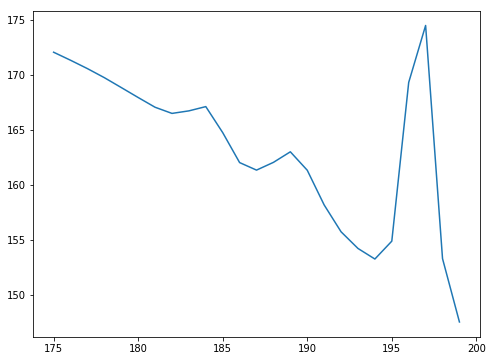

In [146]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'][-25:].plot(figsize=(8, 6))

In [147]:
#print(df)

(4, 40, 3)
==== 0 0 0
X_train[0 0 0 0 ] =  -0.5372549019607843  (59.0)
 m:  [-0.5259871] ([60.436646])
 E[m]:  -0.5259871 ([60.436646])
 invs:  [5.061367]
 weights:  [1.]  ( [0.04086556] )
 pvals:  57    0.018117
58    0.057689
59    0.155393
60    0.280793
61    0.268938
62    0.139294
63    0.050107
64    0.015562
dtype: float64
 pixel_val:  60
==== 0 0 1
X_train[0 0 0 1 ] =  -0.5137254901960784  (62.0)
 m:  [-0.50435984] ([63.194122])
 E[m]:  -0.50435984 ([63.194122])
 invs:  [4.621604]
 weights:  [1.]  ( [0.03899233] )
 pvals:  58    0.012582
59    0.026814
60    0.054557
61    0.101235
62    0.159318
63    0.195599
64    0.178408
65    0.123690
66    0.070359
67    0.035592
68    0.016939
dtype: float64
 pixel_val:  64
==== 0 0 2
X_train[0 0 0 2 ] =  -0.5058823529411764  (63.0)
 m:  [-0.49411237] ([64.50067])
 E[m]:  -0.49411237 ([64.50067])
 invs:  [3.8368258]
 weights:  [1.]  ( [0.03192425] )
 pvals:  55    0.010837
56    0.015175
57    0.021013
58    0.028648
59    0.038243
60 

==== 1 3 0
X_train[0 1 3 0 ] =  -0.6  (51.0)
 m:  [-0.57135534] ([54.65219])
 E[m]:  -0.57135534 ([54.65219])
 invs:  [4.8471327]
 weights:  [1.]  ( [0.04866902] )
 pvals:  51    0.025578
52    0.063196
53    0.135970
54    0.221764
55    0.237867
56    0.163722
57    0.081404
58    0.033981
59    0.013137
dtype: float64
 pixel_val:  56
==== 1 3 1
X_train[0 1 3 1 ] =  -0.788235294117647  (27.0)
 m:  [-0.75253594] ([31.551666])
 E[m]:  -0.75253594 ([31.551666])
 invs:  [3.9822516]
 weights:  [1.]  ( [0.04845607] )
 pvals:  23    0.010984
24    0.016263
25    0.023745
26    0.033969
27    0.047206
28    0.063023
29    0.079785
30    0.094473
31    0.103402
32    0.103868
33    0.095723
34    0.081460
35    0.064753
36    0.048737
37    0.035197
38    0.024666
39    0.016924
40    0.011445
dtype: float64
 pixel_val:  37
==== 1 3 2
X_train[0 1 3 2 ] =  -0.9372549019607843  (8.0)
 m:  [-0.8962574] ([13.2271805])
 E[m]:  -0.8962574 ([13.2271805])
 invs:  [3.1863227]
 weights:  [1.]  ( [0.044

==== 3 0 2
X_train[0 3 0 2 ] =  -0.8666666666666667  (17.0)
 m:  [-0.8241736] ([22.417862])
 E[m]:  -0.8241736 ([22.417862])
 invs:  [3.0564246]
 weights:  [1.]  ( [0.04682405] )
 pvals:  0     0.025253
7     0.011017
8     0.012685
9     0.014543
10    0.016594
11    0.018828
12    0.021230
13    0.023769
14    0.026401
15    0.029068
16    0.031696
17    0.034199
18    0.036481
19    0.038446
20    0.040002
21    0.041070
22    0.041595
23    0.041547
24    0.040930
25    0.039778
26    0.038149
27    0.036125
28    0.033800
29    0.031271
30    0.028631
31    0.025965
32    0.023344
33    0.020825
34    0.018449
35    0.016244
36    0.014225
37    0.012398
38    0.010761
dtype: float64
 pixel_val:  24
==== 3 1 0
X_train[0 3 1 0 ] =  -0.7019607843137254  (38.0)
 m:  [-0.66185445] ([43.113556])
 E[m]:  -0.66185445 ([43.113556])
 invs:  [4.6833014]
 weights:  [1.]  ( [0.0552068] )
 pvals:  38    0.011110
39    0.024998
40    0.053688
41    0.104596
42    0.169892
43    0.208428
44    0

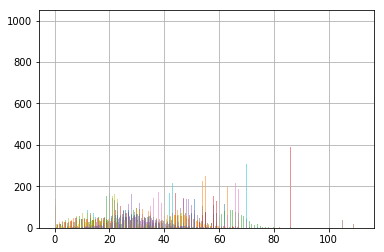

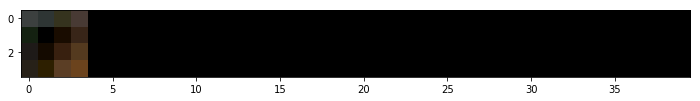

Elapsed:  16.426818132400513


In [148]:
debug = True

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                # =======================================================
                #x_out = model.predict(X_train, num_samples)
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * mixture_components
                    x_ms = x_out[n, i, j, offset:offset + mixture_components]
                    offset = mixture_components * img_chns + k * mixture_components

                    x_invs = x_out[n, i, j, offset:offset + mixture_components]
                    offset = 2 * mixture_components * img_chns + k * mixture_components
                    weights = softmax(x_out[n, i, j, offset:offset + mixture_components])
                    pvals = compute_mixture(x_ms, x_invs, weights, mixture_components)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = (pixel_val - 127.5) / 127.5
                    if 0 <= i <= 3 and 0 <= j <= 3 and debug:
                        print("====", i, j, k)
                        print("X_train[0", i, j, k, "] = ", X_train[0, i, j, k], 
                              " (%s)" % (X_train[0, i, j, k] * 127.5 + 127.5))
                        print(" m: ", x_ms, "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" E[m]: ", (x_ms * weights).sum(), "(%s)" % (x_ms * 127.5 + 127.5))
                        print(" invs: ", x_invs)
                        print(" weights: ", weights, " (", x_out[n, i, j, offset:offset + mixture_components] ,")")
                        s = pd.Series(pvals)
                        print(" pvals: ", s[s>1e-2])
                        print(" pixel_val: ", pixel_val)
                        samples = pd.Series(np.random.choice(len(pvals), 1000, p=pvals / pvals.sum()))
                        samples.hist(bins=128, alpha=0.5, label='generated')
                        #print("====", i, j, k)
                        #print(" m: ", x_ms)
                        #print(" invs: ", x_invs)
                        #print(" weights: ", weights)
                        #print(" pixel_val: ", pixel_val)
                        #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                        #print(" x_out: ", x_out)
                        #print(" sample_val: ", x_sample[n, i, j, k])
                        #print(" pvals: ", pvals)
        if debug:
            print("row", i)
        
                
    return (x_sample * 127.5 + 127.5)


start = time.time()

n = 1 if debug else 10
figure = np.zeros((img_rows * ((n - 1) // 10 + 1), img_cols * 10, img_chns))
print(figure.shape)
# num_samples = batch_size
num_samples = 1
for i in range(1):
    samples = gen_image(model, num_samples=num_samples)
    for j in range(num_samples):
        img = samples[j] / 255.
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

In [149]:
#display(X_train[0] * 127.5 + 127.5)
#display(samples[0])

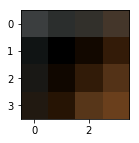

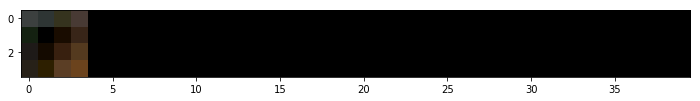

In [150]:
plt.figure(figsize=(2, 2))
plt.imshow((X_train[0] * 127.5 + 127.5) / 255.)
plt.show()

plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

# 2019-05-28

* Trying the full architecture on larger and larger sizes of a single image.
* The results look promising!
* Training Notes:
  * You have to leave it training longer on a smaller learning rate `0.0005`, just use early stopping
  * `Adam` seems to converge faster than `RMSprop`
  * Have to use some ResNet blocks or else don't have enough expressiveness!
  * Having under-trained it a bit, it seems to follow my previous intuition: it gets the `m` in the general vicinity first, then with some more training will move towards larger `invs` values (tighter distributions)
* Here are some of the examples so far on 4x4 image segment:
  
              (4, 40, 3)
            ==== 0 0 0
            X_train[0 0 0 0 ] =  -0.5372549019607843  (59.0)
             m:  [-0.5259871] ([60.436646])
             E[m]:  -0.5259871 ([60.436646])
             invs:  [5.061367]
             weights:  [1.]  ( [0.04086556] )
             pvals:  57    0.018117
            58    0.057689
            59    0.155393
            60    0.280793
            61    0.268938
            62    0.139294
            63    0.050107
            64    0.015562
            dtype: float64
             pixel_val:  60
            ==== 0 0 1
            X_train[0 0 0 1 ] =  -0.5137254901960784  (62.0)
             m:  [-0.50435984] ([63.194122])
             E[m]:  -0.50435984 ([63.194122])
             invs:  [4.621604]
             weights:  [1.]  ( [0.03899233] )
             pvals:  58    0.012582
            59    0.026814
            60    0.054557
            61    0.101235
            62    0.159318
            63    0.195599
            64    0.178408
            65    0.123690
            66    0.070359
            67    0.035592
            68    0.016939
            dtype: float64
             pixel_val:  64
            ==== 0 0 2
            X_train[0 0 0 2 ] =  -0.5058823529411764  (63.0)
             m:  [-0.49411237] ([64.50067])
             E[m]:  -0.49411237 ([64.50067])
             invs:  [3.8368258]
             weights:  [1.]  ( [0.03192425] )
             pvals:  55    0.010837
            56    0.015175
            57    0.021013
            58    0.028648
            59    0.038243
            60    0.049641
            61    0.062141
            62    0.074352
            63    0.084302
            64    0.089945
            65    0.089949
            66    0.084313
            67    0.074367
            68    0.062158
            69    0.049657
            70    0.038258
            71    0.028660
            72    0.021022
            73    0.015182
            74    0.010842
            dtype: float64
             pixel_val:  63
            ==== 0 1 0
            X_train[0 0 1 0 ] =  -0.6627450980392157  (43.0)
             m:  [-0.6455063] ([45.197945])
             E[m]:  -0.6455063 ([45.197945])
             invs:  [4.824808]
             weights:  [1.]  ( [0.04896531] )
             pvals:  41    0.016215
            42    0.040601
            43    0.093048
            44    0.175924
            45    0.237396
            46    0.207849
            47    0.123470
            48    0.057234
            49    0.023468
            dtype: float64
             pixel_val:  46
            ==== 0 1 1
            X_train[0 0 1 1 ] =  -0.6392156862745098  (46.0)
             m:  [-0.6224542] ([48.137085])
             E[m]:  -0.6224542 ([48.137085])
             invs:  [4.2934394]
             weights:  [1.]  ( [0.04909106] )
             pvals:  42    0.016153
            43    0.027407
            44    0.045007
            45    0.070084
            46    0.100585
            47    0.128664
            48    0.142369
            49    0.134339
            50    0.109004
            51    0.078120
            52    0.051142
            53    0.031525
            54    0.018717
            55    0.010866
            dtype: float64
             pixel_val:  53
            
Original:           
<img src="images/2019-05-28-image2.png">

Generated:           
<img src="images/2019-05-28-image1.png">